<a href="https://colab.research.google.com/github/thegith45/Decentralized-learning/blob/main/FedNova.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install --upgrade torch torchvision torchaudio

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import copy
import os

# ---------------------------
# Reproducibility
# ---------------------------
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- Simple CNN Model (MNIST: 1x28x28) ---
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)           # -> (10, 24, 24)
        self.pool = nn.MaxPool2d(2)                # -> (10, 12, 12)
        self.fc1 = nn.Linear(10 * 12 * 12, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 10 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# --- Data: MNIST ---
transform = transforms.Compose([transforms.ToTensor()])
data_root = './data'
os.makedirs(data_root, exist_ok=True)

train_dataset = datasets.MNIST(root=data_root, train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root=data_root, train=False, download=True, transform=transform)

# Validation split
val_ratio = 0.1
num_train = len(train_dataset)
all_indices = np.arange(num_train)
np.random.shuffle(all_indices)
val_size = int(val_ratio * num_train)
val_indices = all_indices[:val_size]
train_indices = all_indices[val_size:]

train_subset = Subset(train_dataset, train_indices.tolist())
val_subset   = Subset(train_dataset, val_indices.tolist())

# --- IID partition (isolate system heterogeneity effects) ---
def iid_partition_indices(indices, num_clients):
    indices = np.array(indices)
    shuffled = np.random.permutation(indices)
    splits = np.array_split(shuffled, num_clients)
    return {i: splits[i] for i in range(num_clients)}

# --- Local training: returns weights + number of SGD steps ---
def local_train(model, dataset, epochs, batch_size, lr):
    model.train()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    num_steps = 0
    for _ in range(epochs):
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            num_steps += 1
    return model.state_dict(), num_steps

# --- Aggregation: FedAvg (weighted by data size) ---
def fedavg_aggregate(client_updates):
    avg_state = {}
    total = sum(c['dsize'] for c in client_updates)
    keys = client_updates[0]['weights'].keys()
    for k in keys:
        avg_state[k] = sum(c['weights'][k] * (c['dsize'] / total) for c in client_updates)
    return avg_state

# --- Aggregation: FedNova (normalize by local steps) ---
def fednova_aggregate(global_state, client_updates):
    agg_delta = {k: torch.zeros_like(v) for k, v in global_state.items()}
    total = sum(c['dsize'] for c in client_updates)

    for c in client_updates:
        weight = c['dsize'] / total
        tau = max(1, c['steps'])  # safety
        for k in global_state.keys():
            delta = c['weights'][k] - global_state[k]   # client minus global
            norm_delta = delta / tau                    # normalize by steps
            agg_delta[k] += weight * norm_delta

    new_state = copy.deepcopy(global_state)
    for k in new_state.keys():
        new_state[k] += agg_delta[k]
    return new_state

# --- Evaluation helpers ---
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            correct += (preds == target).sum().item()
            total += target.size(0)
    return 100.0 * correct / total

def get_preds_labels(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.numpy())
    return np.array(all_preds), np.array(all_labels)

# --- Federated training (FedAvg or FedNova) with system heterogeneity ---
def federated_train(
    train_subset,
    algorithm='fedavg',
    num_clients=10,
    rounds=20,
    local_epoch_range=(2, 8),
    batch_size=64,
    lr=0.01,
    seed_for_round_sync=None,   # set to seed to align epoch draws across algs
    verbose=True
):
    if verbose:
        print(f"\n=== {algorithm.upper()} training under System Heterogeneity ===")
    client_map = iid_partition_indices(train_subset.indices, num_clients)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
    val_loader  = DataLoader(val_subset,  batch_size=256, shuffle=False)

    global_model = SimpleCNN().to(device)
    test_curve, val_curve = [], []

    # ensure same heterogeneity pattern across algs if seed given
    rng = np.random.RandomState(seed_for_round_sync) if seed_for_round_sync is not None else np.random

    for r in range(rounds):
        client_epochs = rng.randint(low=local_epoch_range[0], high=local_epoch_range[1] + 1, size=num_clients)
        if verbose:
            print(f"Round {r+1}/{rounds} | client epochs: {client_epochs}")

        client_updates = []
        for cid in range(num_clients):
            local_model = SimpleCNN().to(device)
            local_model.load_state_dict(global_model.state_dict())

            client_idx = client_map[cid].tolist()
            client_subset = Subset(train_dataset, client_idx)

            local_weights, steps = local_train(
                local_model, client_subset, epochs=int(client_epochs[cid]),
                batch_size=batch_size, lr=lr
            )
            client_updates.append({
                'weights': local_weights,
                'steps': steps,
                'dsize': len(client_subset)
            })

        g_state = global_model.state_dict()
        if algorithm.lower() == 'fednova':
            new_state = fednova_aggregate(g_state, client_updates)
        else:
            new_state = fedavg_aggregate(client_updates)

        global_model.load_state_dict(new_state)

        # evaluate each round
        test_acc = evaluate(global_model, test_loader)
        val_acc  = evaluate(global_model, val_loader)
        test_curve.append(test_acc)
        val_curve.append(val_acc)
        if verbose:
            print(f"  -> Val: {val_acc:.2f}% | Test: {test_acc:.2f}%")

    return {'val': val_curve, 'test': test_curve, 'model': global_model}

# ---------------------------
# Run experiments
# ---------------------------
num_clients = 10
rounds = 15
local_epoch_range = (2, 8)     # simulating system heterogeneity
batch_size = 64
lr = 0.01

# FedAvg
fedavg_results = federated_train(
    train_subset,
    algorithm='fedavg',
    num_clients=num_clients,
    rounds=rounds,
    local_epoch_range=local_epoch_range,
    batch_size=batch_size,
    lr=lr,
    seed_for_round_sync=seed,   # synchronize epoch draws
    verbose=True
)

# FedNova (same heterogeneity pattern)
fednova_results = federated_train(
    train_subset,
    algorithm='fednova',
    num_clients=num_clients,
    rounds=rounds,
    local_epoch_range=local_epoch_range,
    batch_size=batch_size,
    lr=lr,
    seed_for_round_sync=seed,   # synchronize epoch draws
    verbose=True
)


Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 11.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 339kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.15MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.85MB/s]



=== FEDAVG training under System Heterogeneity ===
Round 1/15 | client epochs: [8 5 6 8 4 6 6 8 3 4]
  -> Val: 85.63% | Test: 86.40%
Round 2/15 | client epochs: [8 4 4 6 5 4 7 6 3 5]
  -> Val: 89.68% | Test: 90.15%
Round 3/15 | client epochs: [7 7 3 5 6 2 5 3 7 6]
  -> Val: 90.95% | Test: 91.29%
Round 4/15 | client epochs: [5 2 2 4 4 8 3 5 5 8]
  -> Val: 91.72% | Test: 91.91%
Round 5/15 | client epochs: [7 7 8 7 4 5 8 5 2 4]
  -> Val: 92.73% | Test: 92.64%
Round 6/15 | client epochs: [6 4 8 6 2 8 3 5 2 5]
  -> Val: 93.02% | Test: 93.07%
Round 7/15 | client epochs: [7 3 3 2 3 6 3 5 5 8]
  -> Val: 93.53% | Test: 93.55%
Round 8/15 | client epochs: [5 8 5 6 8 4 7 2 5 3]
  -> Val: 94.27% | Test: 94.14%
Round 9/15 | client epochs: [5 3 7 7 7 3 5 7 6 8]
  -> Val: 94.55% | Test: 94.58%
Round 10/15 | client epochs: [3 3 5 3 3 7 5 7 8 8]
  -> Val: 94.97% | Test: 94.95%
Round 11/15 | client epochs: [7 8 5 2 7 6 6 3 8 6]
  -> Val: 95.18% | Test: 95.30%
Round 12/15 | client epochs: [3 2 5 5 5 6 2 

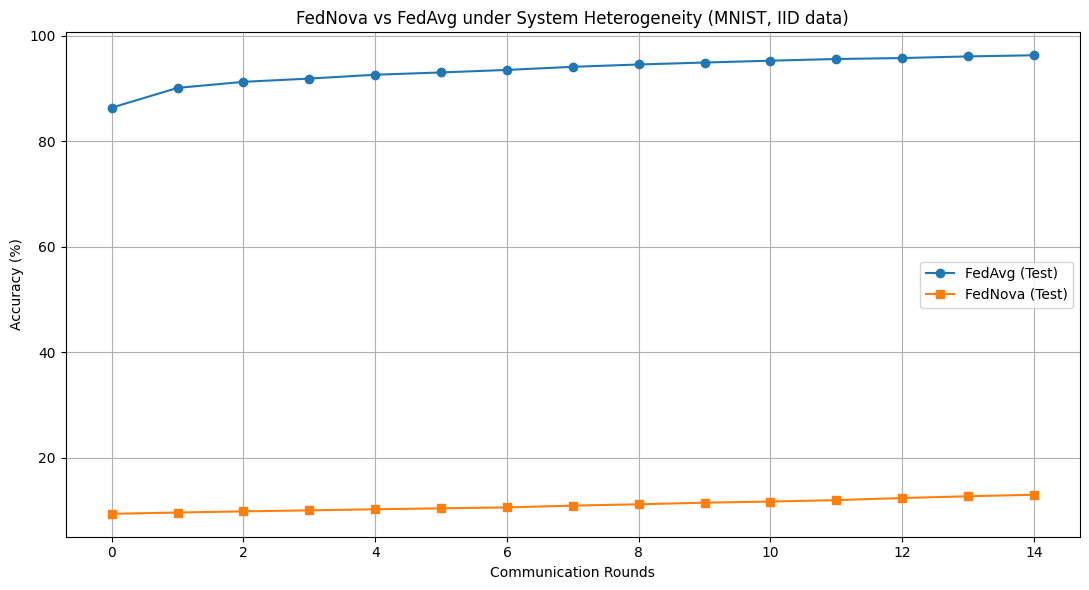


### Final Evaluation: FedAvg ###
              precision    recall  f1-score   support

           0     0.9612    0.9867    0.9738       980
           1     0.9807    0.9859    0.9833      1135
           2     0.9629    0.9545    0.9586      1032
           3     0.9458    0.9683    0.9569      1010
           4     0.9683    0.9644    0.9663       982
           5     0.9758    0.9484    0.9619       892
           6     0.9616    0.9666    0.9641       958
           7     0.9647    0.9582    0.9614      1028
           8     0.9546    0.9497    0.9521       974
           9     0.9569    0.9465    0.9517      1009

    accuracy                         0.9633     10000
   macro avg     0.9633    0.9629    0.9630     10000
weighted avg     0.9634    0.9633    0.9633     10000



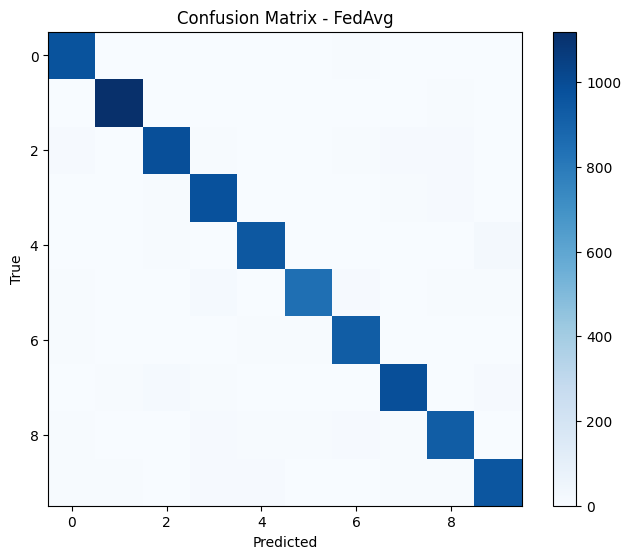


### Final Evaluation: FedNova ###


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       980
           1     0.0000    0.0000    0.0000      1135
           2     0.1503    0.2888    0.1977      1032
           3     0.0000    0.0000    0.0000      1010
           4     0.1628    0.8676    0.2741       982
           5     0.0000    0.0000    0.0000       892
           6     0.0000    0.0000    0.0000       958
           7     0.0000    0.0000    0.0000      1028
           8     0.0547    0.1561    0.0810       974
           9     0.0000    0.0000    0.0000      1009

    accuracy                         0.1302     10000
   macro avg     0.0368    0.1312    0.0553     10000
weighted avg     0.0368    0.1302    0.0552     10000



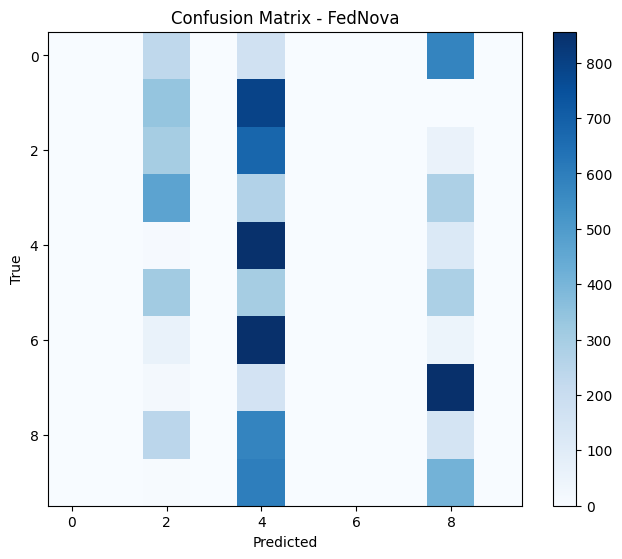

In [4]:
# Plot convergence (Test Accuracy)
plt.figure(figsize=(11, 6))
plt.plot(fedavg_results['test'],  label='FedAvg (Test)',  marker='o')
plt.plot(fednova_results['test'], label='FedNova (Test)', marker='s')
plt.xlabel('Communication Rounds')
plt.ylabel('Accuracy (%)')
plt.title('FedNova vs FedAvg under System Heterogeneity (MNIST, IID data)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Final evaluation & diagnostics
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

for name, res in [('FedAvg', fedavg_results), ('FedNova', fednova_results)]:
    print(f"\n### Final Evaluation: {name} ###")
    model = res['model']
    preds, labels = get_preds_labels(model, test_loader)
    print(classification_report(labels, preds, digits=4))
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(6.8,5.6))
    plt.imshow(cm, cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.colorbar()
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.tight_layout()
    plt.show()
